<a href="https://colab.research.google.com/github/GitAIwithMike/ATC-Models/blob/main/atc_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the repository
!git clone https://github.com/GitAIwithMike/ATC-Models.git
%cd ATC-Models

# Install the required libraries
!pip install torch transformers datasets librosa pydub


fatal: destination path 'ATC-Models' already exists and is not an empty directory.
/content/ATC-Models


Audio file downloaded and saved to: processed_audio.wav
Loaded processed audio file.
Original Sample Rate: 44100
Resampled Sample Rate: 16000
Duration: 850.83 seconds


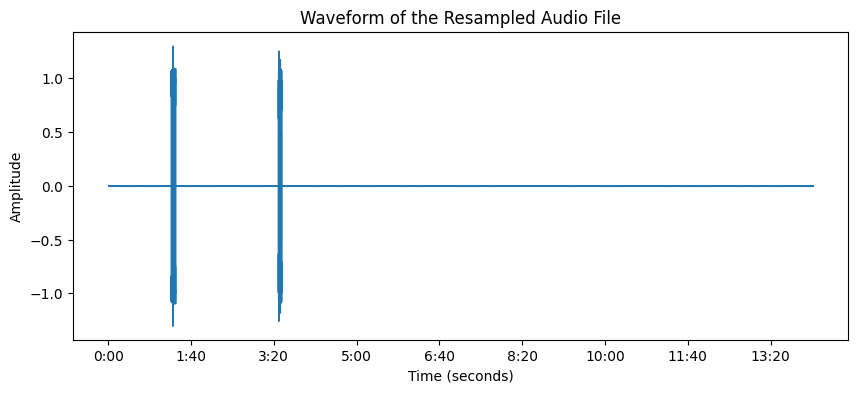

MFCC features saved to ../data/tartanaviation/processed/processed_audio_mfcc.csv


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import required libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# Download and save the audio file locally
def download_audio(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Audio file downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"Failed to download audio file: {e}")

processed_audio_url = "https://raw.githubusercontent.com/GitAIwithMike/ATC-Models/main/data/tartanaviation/processed/processed_audio.wav"
local_audio_path = "processed_audio.wav"

download_audio(processed_audio_url, local_audio_path)

# Load processed audio file
def analyze_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=44100)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        print(f"Loaded processed audio file.")
        print(f"Original Sample Rate: {sr}")
        print(f"Resampled Sample Rate: 16000")
        print(f"Duration: {len(audio) / sr:.2f} seconds")

        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(resampled_audio, sr=16000)
        plt.title("Waveform of the Resampled Audio File")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()
    except Exception as e:
        print(f"Failed to load {audio_path}: {e}")

analyze_audio(local_audio_path)

# Extract MFCC features and save
mfcc_folder = "../data/tartanaviation/processed/"
os.makedirs(mfcc_folder, exist_ok=True)

def extract_mfcc(audio_path, output_folder):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.vstack([mfccs, mfccs_delta, mfccs_delta2])

        mfcc_df = pd.DataFrame(combined_mfccs.T)
        output_path = os.path.join(output_folder, "processed_audio_mfcc.csv")
        mfcc_df.to_csv(output_path, index=False)
        print(f"MFCC features saved to {output_path}")
    except Exception as e:
        print(f"Failed to extract MFCC from {audio_path}: {e}")

extract_mfcc(local_audio_path, mfcc_folder)

# Speech-to-text using Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    except Exception as e:
        print(f"Failed to transcribe {audio_path}: {e}")
        return ""

transcription = transcribe_audio(local_audio_path)
print(f"Transcription: {transcription}")

# Intent classification
intent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
intent_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
intent_labels = ["clearance_request", "alert", "weather_request"]

def classify_intent(transcription):
    try:
        inputs = intent_tokenizer(transcription, return_tensors="pt", truncation=True, padding=True)
        outputs = intent_model(**inputs)
        return intent_labels[torch.argmax(outputs.logits, dim=-1).item()]
    except Exception as e:
        print(f"Failed to classify intent for transcription: {e}")
        return "unknown"

intent = classify_intent(transcription)
print(f"Detected Intent: {intent}")

# Suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}!"
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}!"
    else:
        return "No action required."

trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

action = suggest_action(intent, trajectory_data, weather_data)
print(f"Suggested Action: {action}")

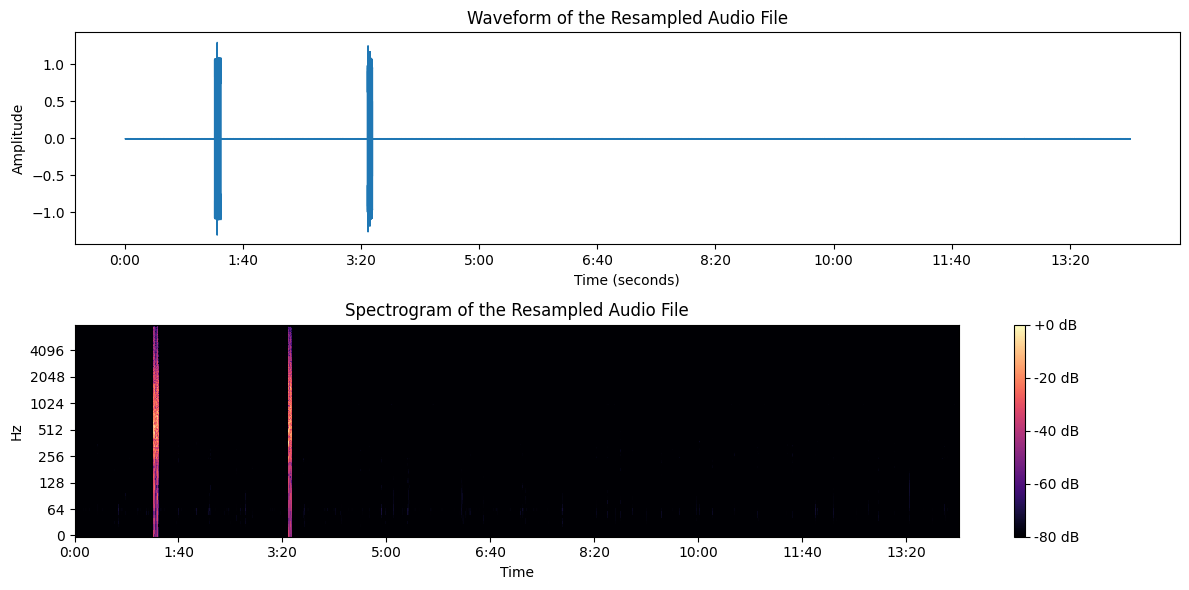

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import required libraries
import os
import logging
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to download and save the audio file locally
def download_audio(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
        logging.info(f"Audio file downloaded and saved to: {save_path}")
    except Exception as e:
        logging.error(f"Failed to download audio file: {e}")

# Dynamic paths
data_folder = os.path.join(os.getcwd(), "data", "tartanaviation", "processed")
os.makedirs(data_folder, exist_ok=True)
local_audio_path = os.path.join(data_folder, "processed_audio.wav")

# URL of the processed audio file
processed_audio_url = "https://raw.githubusercontent.com/GitAIwithMike/ATC-Models/main/data/tartanaviation/processed/processed_audio.wav"
download_audio(processed_audio_url, local_audio_path)

# Function to analyze the audio
def analyze_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=44100)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        logging.info(f"Loaded processed audio file.")
        logging.info(f"Original Sample Rate: {sr}")
        logging.info(f"Resampled Sample Rate: 16000")
        logging.info(f"Duration: {len(audio) / sr:.2f} seconds")

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(resampled_audio, sr=16000)
        plt.title("Waveform of the Resampled Audio File")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")

        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(resampled_audio)), ref=np.max)
        librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='log')
        plt.title("Spectrogram of the Resampled Audio File")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Failed to analyze {audio_path}: {e}")

analyze_audio(local_audio_path)

# Function to extract MFCC features
def extract_mfcc(audio_path, output_folder):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.vstack([mfccs, mfccs_delta, mfccs_delta2])

        mfcc_df = pd.DataFrame(combined_mfccs.T)
        output_path = os.path.join(output_folder, "processed_audio_mfcc.csv")
        mfcc_df.to_csv(output_path, index=False)
        logging.info(f"MFCC features saved to {output_path}")
    except Exception as e:
        logging.error(f"Failed to extract MFCC from {audio_path}: {e}")

extract_mfcc(local_audio_path, data_folder)

# Load Wav2Vec2 for speech-to-text
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Function to transcribe audio
def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    except Exception as e:
        logging.error(f"Failed to transcribe {audio_path}: {e}")
        return ""

transcription = transcribe_audio(local_audio_path)
logging.info(f"Transcription: {transcription}")

# Intent classification using BERT
intent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
intent_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
intent_labels = ["clearance_request", "alert", "weather_request"]

# Function to classify intent
def classify_intent(transcription):
    try:
        inputs = intent_tokenizer(transcription, return_tensors="pt", truncation=True, padding=True)
        outputs = intent_model(**inputs)
        return intent_labels[torch.argmax(outputs.logits, dim=-1).item()]
    except Exception as e:
        logging.error(f"Failed to classify intent for transcription: {e}")
        return "unknown"

intent = classify_intent(transcription)
logging.info(f"Detected Intent: {intent}")

# Suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}!"
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}!"
    else:
        return "No action required."

trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

action = suggest_action(intent, trajectory_data, weather_data)
logging.info(f"Suggested Action: {action}")


           0    1    2    3    4    5    6    7    8    9  ...   29   30   31  \
0 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

    32   33   34   35   36   37   38  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 39 columns]
                  0             1             2             3             4  \
count  26589.000000  26589.000000  26589.000000  26589.000000  26589.000000   
mean    -443.603737      1.410459     -0.580327     -0.106319     -0.141574   
std       55.877677

In [1]:
pip install transformers torchaudio librosa


In [3]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torchaudio


In [4]:
# Load the pre-trained Wav2Vec2 model and processor from Hugging Face
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Load the processed audio file
def load_audio(audio_path):
    # Use torchaudio to load the audio, which handles many formats like WAV, MP3, etc.
    waveform, sample_rate = torchaudio.load(audio_path)
    return waveform, sample_rate

# Resample audio to match model's expected sample rate (16kHz)
def preprocess_audio(waveform, sample_rate, target_sample_rate=16000):
    # Resample if necessary
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    return waveform

# Example usage
audio_path = '/content/ATC-Models/data/tartanaviation/processed/processed_audio.wav'
waveform, sample_rate = load_audio(audio_path)
waveform = preprocess_audio(waveform, sample_rate)


In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torchaudio

# Load the model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load and preprocess audio
def load_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    return waveform, sample_rate

# Resample audio to match model's expected sample rate (16kHz)
def preprocess_audio(waveform, sample_rate, target_sample_rate=16000):
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    # Ensure the tensor shape is (batch_size, num_samples)
    if waveform.dim() == 2:
        waveform = waveform.squeeze(0)  # Remove extra dimension if present
    return waveform

# Transcribe audio
def transcribe_audio(waveform):
    # Preprocess audio for Wav2Vec2
    inputs = processor(waveform, return_tensors="pt", sampling_rate=16000)

    # Perform inference with the model
    with torch.no_grad():
        logits = model(input_values=inputs.input_values).logits

    # Decode the output
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

# Path to the processed audio file
audio_path = '/content/ATC-Models/data/tartanaviation/processed/processed_audio.wav'

# Load and preprocess the audio
waveform, sample_rate = load_audio(audio_path)
waveform = preprocess_audio(waveform, sample_rate)

# Perform transcription
transcription = transcribe_audio(waveform)

# Print the transcription
print(f"Transcription: {transcription}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torchaudio

# Load the model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load and preprocess audio
def load_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    return waveform, sample_rate

# Resample audio to match model's expected sample rate (16kHz)
def preprocess_audio(waveform, sample_rate, target_sample_rate=16000):
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    # Ensure the tensor shape is (batch_size, num_samples)
    if waveform.dim() == 2:
        waveform = waveform.squeeze(0)  # Remove extra dimension if present
    return waveform

# Transcribe audio
def transcribe_audio(waveform):
    # Preprocess audio for Wav2Vec2
    inputs = processor(waveform, return_tensors="pt", sampling_rate=16000)

    # Perform inference with the model
    with torch.no_grad():
        logits = model(input_values=inputs.input_values).logits

    # Decode the output
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

# Path to the processed audio file
audio_path = '/content/ATC-Models/notebooks/processed_audio.wavv'

# Check if the audio file is too large
import os
audio_size = os.path.getsize(audio_path)
max_size = 50 * 1024 * 1024  # 50MB max size

if audio_size > max_size:
    print("Audio file is too large! Consider trimming or reducing the size.")
else:
    # Load and preprocess the audio
    waveform, sample_rate = load_audio(audio_path)
    waveform = preprocess_audio(waveform, sample_rate)

    # Perform transcription
    try:
        transcription = transcribe_audio(waveform)
        print(f"Transcription: {transcription}")
    except Exception as e:
        print(f"Error during transcription: {e}")


In [5]:
import os
file_path = '/content/ATC-Models/notebooks/processed_audio.wav'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found at {file_path}")


File found: /content/ATC-Models/notebooks/processed_audio.wav


In [7]:
pip install SpeechRecognition pydub matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 11.4 MB/s eta 0:00:00


Transcription: hey Google hey Google hey Google hey Google hey Google hey Google hey Google


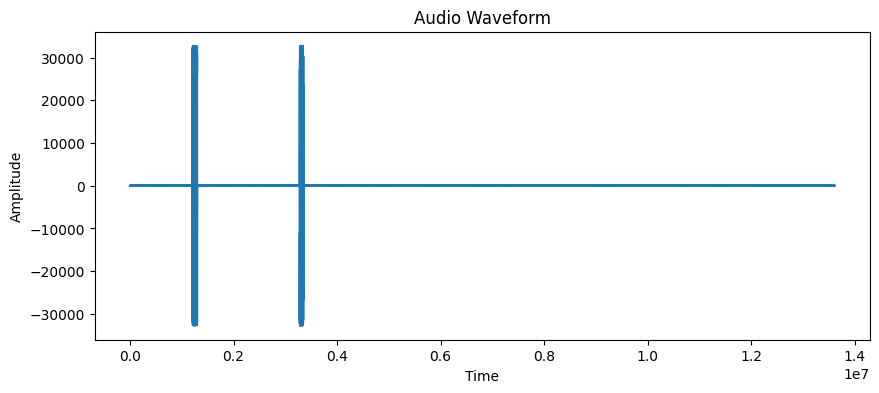

In [8]:
import speech_recognition as sr
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

# Path to your audio file
audio_path = "/content/ATC-Models/notebooks/processed_audio.wav"

# Initialize the recognizer
recognizer = sr.Recognizer()

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)  # Record the audio from the file
        try:
            text = recognizer.recognize_google(audio)  # Use Google's speech recognition
            return text
        except sr.UnknownValueError:
            return "Sorry, could not understand the audio."
        except sr.RequestError as e:
            return f"Request error: {e}"

# Function to visualize the waveform of the audio
def plot_waveform(audio_path):
    # Load the audio file using pydub
    sound = AudioSegment.from_wav(audio_path)

    # Get the audio samples
    samples = np.array(sound.get_array_of_samples())

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(samples)
    plt.title("Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Transcribe the audio
transcription = transcribe_audio(audio_path)
print(f"Transcription: {transcription}")

# Visualize the audio waveform
plot_waveform(audio_path)


Transcription: hey Google hey Google hey Google hey Google hey Google hey Google hey Google


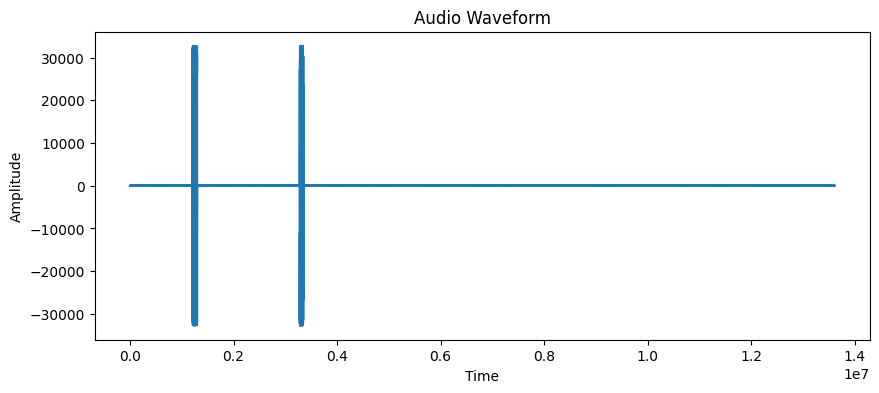

In [ ]:
import speech_recognition as sr
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

# Path to your audio file
audio_path = "/content/ATC-Models/notebooks/processed_audio.wav"

# Initialize the recognizer
recognizer = sr.Recognizer()

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)  # Record the audio from the file
        try:
            text = recognizer.recognize_google(audio)  # Use Google's speech recognition
            return text
        except sr.UnknownValueError:
            return "Sorry, could not understand the audio."
        except sr.RequestError as e:
            return f"Request error: {e}"

# Function to visualize the waveform of the audio
def plot_waveform(audio_path):
    # Load the audio file using pydub
    sound = AudioSegment.from_wav(audio_path)

    # Get the audio samples
    samples = np.array(sound.get_array_of_samples())

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(samples)
    plt.title("Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Transcribe the audio
transcription = transcribe_audio(audio_path)
print(f"Transcription: {transcription}")

# Visualize the audio waveform
plot_waveform(audio_path)


Transcription: hey Google hey Google hey Google hey Google hey Google hey Google hey Google


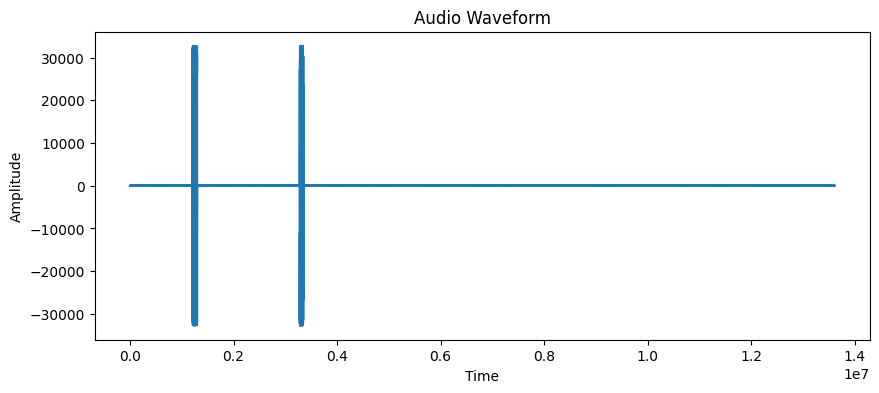

In [9]:
import speech_recognition as sr
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

# Path to your audio file
audio_path = "/content/ATC-Models/data/tartanaviation/processed/processed_audio.wav"

# Initialize the recognizer
recognizer = sr.Recognizer()

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)  # Record the audio from the file
        try:
            text = recognizer.recognize_google(audio)  # Use Google's speech recognition
            return text
        except sr.UnknownValueError:
            return "Sorry, could not understand the audio."
        except sr.RequestError as e:
            return f"Request error: {e}"

# Function to visualize the waveform of the audio
def plot_waveform(audio_path):
    # Load the audio file using pydub
    sound = AudioSegment.from_wav(audio_path)

    # Get the audio samples
    samples = np.array(sound.get_array_of_samples())

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(samples)
    plt.title("Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Transcribe the audio
transcription = transcribe_audio(audio_path)
print(f"Transcription: {transcription}")

# Visualize the audio waveform
plot_waveform(audio_path)


Transcription: weather traffic 79819 North Carolina


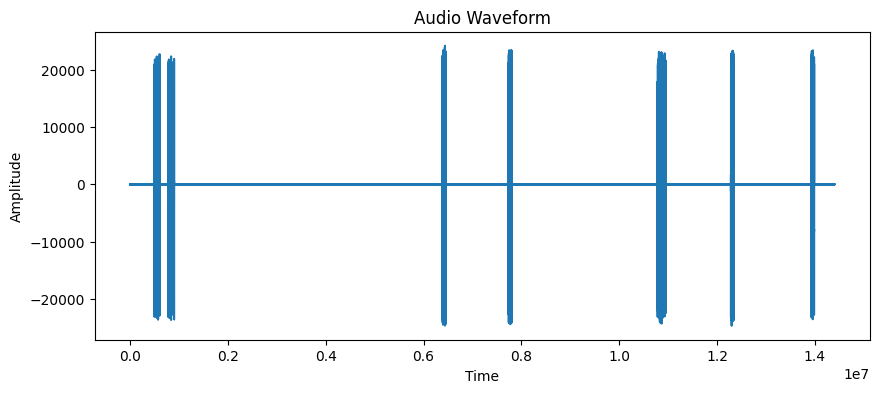

In [12]:
import speech_recognition as sr
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

# Path to your audio file
audio_path = "/content/ATC-Models/data/tartanaviation/processed/8.wav"

# Initialize the recognizer
recognizer = sr.Recognizer()

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)  # Record the audio from the file
        try:
            text = recognizer.recognize_google(audio)  # Use Google's speech recognition
            return text
        except sr.UnknownValueError:
            return "Sorry, could not understand the audio."
        except sr.RequestError as e:
            return f"Request error: {e}"

# Function to visualize the waveform of the audio
def plot_waveform(audio_path):
    # Load the audio file using pydub
    sound = AudioSegment.from_wav(audio_path)

    # Get the audio samples
    samples = np.array(sound.get_array_of_samples())

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(samples)
    plt.title("Audio Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Transcribe the audio
transcription = transcribe_audio(audio_path)
print(f"Transcription: {transcription}")

# Visualize the audio waveform
plot_waveform(audio_path)


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB # Changed to GaussianNB
from sklearn.metrics import classification_report
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Step 1: Load your CSV file into a pandas dataframe
csv_file_path = '/content/ATC-Models/notebooks/Cleaned Data Files/cleaned_AGC.csv'  # Update this path as needed
df = pd.read_csv(csv_file_path)

# Display first few rows to understand the structure of your data
print(df.head())

# Step 2: Define the target variable (for example, based on 'wxcodes' column)
df['weather_condition'] = df['wxcodes'].apply(lambda x: 'Snow' if 'SN' in x else ('Rain' if 'RA' in x else 'Clear'))

# Step 3: Choose relevant features (e.g., `tmpf`, `dwpf`, `relh`, `drct`, etc.)
# Here, we use a simple example of just `tmpf` and `relh` for prediction
X = df[['tmpf', 'relh']]  # Features
y = df['weather_condition']  # Target variable

# Convert 'tmpf' and 'relh' columns to numeric, handling errors
X['tmpf'] = pd.to_numeric(X['tmpf'], errors='coerce')
X['relh'] = pd.to_numeric(X['relh'], errors='coerce')

# Remove rows with missing values (NaN) in 'tmpf' or 'relh'
X.dropna(subset=['tmpf', 'relh'], inplace=True)
y = y[X.index]  # Update y to match the filtered X

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train a Gaussian Naive Bayes Classifier (better for continuous data)
model = GaussianNB()  # Use GaussianNB for continuous data like tmpf and relh

# Fit the model to the training data
model.fit(X_train, y_train)

# Step 6: Predict and Evaluate the Model
y_pred = model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred))

# Step 7: Classify new data
new_data = pd.DataFrame({'tmpf': [32.0], 'relh': [80]})  # Sample data to classify
predicted_condition = model.predict(new_data)

print(f"Predicted weather condition: {predicted_condition[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-21-bdbd9d2ae96a>:11: DtypeWarning: Columns (5,6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-21-bdbd9d2ae96a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tmpf'] = pd.to_numeric(X['tmpf'], errors='coerce')
<ipython-input-21-bdbd9d2ae96a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  station                valid      lon      lat  elevation   tmpf   dwpf  \
0     AGC  2020-01-01 00:42:00 -79.9217  40.3547      382.0  32.00  27.00   
1     AGC  2020-01-01 00:53:00 -79.9217  40.3547      382.0  32.00  27.00   
2     AGC  2020-01-01 01:32:00 -79.9217  40.3547      382.0  32.00  28.00   
3     AGC  2020-01-01 01:49:00 -79.9217  40.3547      382.0  32.00  28.40   
4     AGC  2020-01-01 01:53:00 -79.9217  40.3547      382.0  32.00  28.00   

    relh    drct   sknt  ... wxcodes ice_accretion_1hr ice_accretion_3hr  \
0  81.55  240.00  16.00  ...     -SN                 M                 M   
1  81.55  240.00  12.00  ...     -SN                 M                 M   
2  84.98  240.00  14.00  ...  -SN BR                 M                 M   
3  86.39  250.00  14.00  ...  -SN BR                 M                 M   
4  84.98  250.00  15.00  ...  -SN BR                 M                 M   

  ice_accretion_6hr peak_wind_gust peak_wind_drct    peak_wind_time   feel  \
0 

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB # Changed to GaussianNB
from sklearn.metrics import classification_report
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Step 1: Load your CSV file into a pandas dataframe
csv_file_path = '/content/ATC-Models/notebooks/Cleaned Data Files/cleaned_BTP.csv'  # Update this path as needed
df = pd.read_csv(csv_file_path)

# Display first few rows to understand the structure of your data
print(df.head())

# Step 2: Define the target variable (for example, based on 'wxcodes' column)
df['weather_condition'] = df['wxcodes'].apply(lambda x: 'Snow' if 'SN' in x else ('Rain' if 'RA' in x else 'Clear'))

# Step 3: Choose relevant features (e.g., `tmpf`, `dwpf`, `relh`, `drct`, etc.)
# Here, we use a simple example of just `tmpf` and `relh` for prediction
X = df[['tmpf', 'relh']]  # Features
y = df['weather_condition']  # Target variable

# Convert 'tmpf' and 'relh' columns to numeric, handling errors
X['tmpf'] = pd.to_numeric(X['tmpf'], errors='coerce')
X['relh'] = pd.to_numeric(X['relh'], errors='coerce')

# Remove rows with missing values (NaN) in 'tmpf' or 'relh'
X.dropna(subset=['tmpf', 'relh'], inplace=True)
y = y[X.index]  # Update y to match the filtered X

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train a Gaussian Naive Bayes Classifier (better for continuous data)
model = GaussianNB()  # Use GaussianNB for continuous data like tmpf and relh

# Fit the model to the training data
model.fit(X_train, y_train)

# Step 6: Predict and Evaluate the Model
y_pred = model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred))

# Step 7: Classify new data
new_data = pd.DataFrame({'tmpf': [32.0], 'relh': [80]})  # Sample data to classify
predicted_condition = model.predict(new_data)

print(f"Predicted weather condition: {predicted_condition[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-22-5bb6df48cce5>:11: DtypeWarning: Columns (5,6,7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-22-5bb6df48cce5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tmpf'] = pd.to_numeric(X['tmpf'], errors='coerce')
<ipython-input-22-5bb6df48cce5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  station                valid      lon      lat  elevation   tmpf   dwpf  \
0     BTP  2020-01-01 00:05:00 -79.9497  40.7769      380.0  30.20  28.40   
1     BTP  2020-01-01 00:17:00 -79.9497  40.7769      380.0  30.20  28.40   
2     BTP  2020-01-01 00:31:00 -79.9497  40.7769      380.0  30.20  28.40   
3     BTP  2020-01-01 00:56:00 -79.9497  40.7769      380.0  30.00  28.90   
4     BTP  2020-01-01 00:59:00 -79.9497  40.7769      380.0  30.20  28.40   

    relh    drct   sknt  ... wxcodes ice_accretion_1hr ice_accretion_3hr  \
0  92.92  260.00   8.00  ...  -SN BR                 M                 M   
1  92.92  250.00   8.00  ...  -SN BR                 M                 M   
2  92.92  240.00  10.00  ...  -SN BR                 M                 M   
3  95.61  290.00   8.00  ...  -SN BR                 M                 M   
4  92.92  270.00   8.00  ...  -SN BR                 M                 M   

  ice_accretion_6hr peak_wind_gust peak_wind_drct peak_wind_time   feel  \
0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Clear       0.83      0.94      0.88      8142
        Rain       0.00      0.00      0.00      1206
        Snow       0.52      0.59      0.55       913

    accuracy                           0.80     10261
   macro avg       0.45      0.51      0.48     10261
weighted avg       0.70      0.80      0.75     10261

Predicted weather condition: Clear


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
!pip install tensorflow


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Step 1: Load the data
csv_file_path = '/content/ATC-Models/notebooks/processed_audio.wav'
df = pd.read_csv(csv_file_path)

# Step 2: Data Cleaning
df = df[['tmpf', 'relh', 'drct', 'wxcodes']]  # Choose the features and the target
df = df.dropna()  # Drop missing values

# Step 3: Create target variable
# Convert 'wxcodes' into simple categories like Rain, Snow, or Clear
df['weather_condition'] = df['wxcodes'].apply(lambda x: 'Snow' if 'SN' in x else ('Rain' if 'RA' in x else 'Clear'))

# Step 4: Encode the target labels into numbers (0 = Clear, 1 = Rain, 2 = Snow)
label_encoder = LabelEncoder()
df['weather_condition'] = label_encoder.fit_transform(df['weather_condition'])

# Step 5: Feature selection (X) and target (y)
X = df[['tmpf', 'relh', 'drct']].values  # Features
y = df['weather_condition'].values  # Target variable

# Step 6: Normalize features (between 0 and 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Step 7: Reshape X for RNN (RNN expects 3D data: (samples, time_steps, features))
# Here, we treat each row as a "time step" for simplicity, so we'll reshape (n_samples, 1, n_features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Step 8: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Build RNN model
model = Sequential()
model.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))  # 3 classes (Clear, Rain, Snow)

# Step 10: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 11: Train the RNN
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 12: Evaluate the RNN
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 13: Predict on new data
new_data = np.array([[30.0, 80, 250]])  # Temperature, humidity, wind direction
new_data = scaler.transform(new_data)  # Normalize
new_data = new_data.reshape((1, 1, 3))  # Reshape to (samples, time_steps, features)
predicted_condition = model.predict(new_data)
predicted_class = np.argmax(predicted_condition)

# Decode the predicted label back to the weather condition
predicted_label = label_encoder.inverse_transform([predicted_class])
print(f"Predicted weather condition: {predicted_label[0]}")



UnicodeDecodeError: 'utf-8' codec can't decode byte 0x9f in position 6: invalid start byte